# Unet

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import ReLU, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import cv2
import os
import re




2023-12-16 16:29:47.741867: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-16 16:29:47.743953: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 16:29:47.770967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 16:29:47.770996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 16:29:47.771840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
## ALTERE AQUI O CAMINHO DAS IMAGENS X e Y
fingerprints = glob(f'finalNovo/fingerprints/*.png')
fingerprints.sort()

ground_truths = glob(f'finalNovo/groundtruths/*.png')
ground_truths.sort()

print(len(fingerprints), len(ground_truths))

X_train, X_val, Y_train, Y_val = train_test_split(fingerprints, ground_truths, test_size=0.2)

print(len(X_train))
print(len(X_val))
print(len(Y_train))
print(len(Y_val))

10000 10000
8000
2000
8000
2000


In [3]:
#Carregar as imagens do disco em lotes
class CustomGenerator(Sequence):
    def __init__(self, image_paths, label_paths, batch_size, image_size=(360, 272)):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_image_paths = self.image_paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_label_paths = self.label_paths[idx * self.batch_size : (idx + 1) * self.batch_size]

        images = []
        labels = []

        for image_path, label_path in zip(batch_image_paths, batch_label_paths):
            # Carregar imagem em escala de cinza com cv2
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#             image = cv2.resize(image, self.image_size)  # Redimensionar para o tamanho desejado
            image = image / 255.0  # Normalização de 0 a 1

            # Carregar rótulo em escala de cinza
            label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
#             label = cv2.resize(label, self.image_size)  # Redimensionar para o tamanho desejado
            label = label / 255.0  # Normalização de 0 a 1

            images.append(image[..., np.newaxis])
            labels.append(label[..., np.newaxis])

        return np.array(images), np.array(labels)


batch_size = 8
training_batch_generator = CustomGenerator(X_train, Y_train, batch_size)
val_batch_generator = CustomGenerator(X_val, Y_val, batch_size)

# print(training_batch_generator[0])
# print(val_batch_generator[0])

In [4]:
# Função para criar um bloco Conv-BatchNorm-ReLU com Dropout opcional
def get_conv_block(x, filters, kernel_size=3, dropout=False):
    conv = Conv2D(filters, kernel_size, padding='same')(x)
    conv = BatchNormalization()(conv)
    conv = ReLU()(conv)
    if dropout:
        conv = Dropout(0.2)(conv)
    conv = Conv2D(filters, kernel_size, padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = ReLU()(conv)
    return conv

# Função para construir a U-Net
def get_unet(input_shape=(360, 272, 1)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = get_conv_block(inputs, 64, dropout=True)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = get_conv_block(pool1, 128, dropout=True)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = get_conv_block(pool2, 256, dropout=True)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = get_conv_block(pool3, 512, dropout=True)

    # Decoder
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = get_conv_block(up5, 256, dropout=True)

    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = get_conv_block(up6, 128, dropout=True)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = get_conv_block(up7, 64, dropout=True)

    # Saída
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model


model = get_unet(input_shape=(360, 272, 1))
adam = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=adam, loss='mean_absolute_error')

model.summary()

2023-12-14 15:22:01.194674: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 15:22:01.194986: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 360, 272, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 360, 272, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 360, 272, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 360, 272, 64)         0         ['batch_normalization[0][0

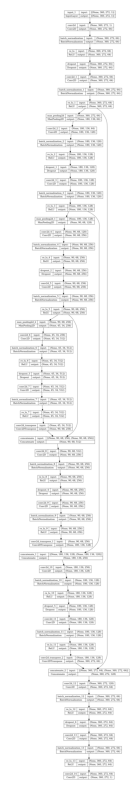

In [5]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_plot.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
model_checkpoint = ModelCheckpoint(
                              filepath='Resultados/model.{epoch:02d}-{val_loss:.3f}.h5',
                              # filepath='/content',
                              save_weights_only=True,
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              save_freq= 'epoch'
                             )

In [8]:
path = 'Resultados'
models = os.listdir('Resultados')
models.sort()

inicio = models[-1]
padrao = r'\.([^.]+)-'
inicio = int(re.search(padrao, inicio).group(1))


In [ ]:

resume_model_path = path + '/' + models[-1]

if os.path.exists(resume_model_path):
    model.load_weights(resume_model_path)
    loaded_weights = model.get_weights()
    if loaded_weights:
        print(f"Modelo carregado com sucesso a partir de {resume_model_path}")
    else:
        print("O arquivo de pesos do modelo não foi encontrado. Iniciando o treinamento a partir do início.")
else:
    loaded_weights = model.get_weights()
    print("O arquivo de pesos do modelo não foi encontrado. Iniciando o treinamento a partir do início.")

# Treine o modelo usando o gerador de lote para treinamento
model.fit(training_batch_generator,
          initial_epoch=inicio,
          epochs=100,
          callbacks=[model_checkpoint,],
          validation_data=val_batch_generator
         )


Modelo carregado com sucesso a partir de drive/MyDrive/PesquisaLeo/Resultados/model.17-0.028.h5
Epoch 18/100
1001/1001 [==============================] - ETA: 0s - loss: 0.0210 